# Labeling medical images using crowdsourcing and statistics


## Data Source

The data used for this analysis comes from a crowdourcing platform used for labeling medical images. The data can be classified into two groups:

<b>Crowd Data</b>: Crowd data is the data provided by users of the platform. Users are provided various medical images and prompted to vote on if they believe there is a medical abnormality present in the image or if the image looks normal and healthy. 

<b>Expert Data</b>: Expert data is the data provided by medical experts in their respective fields. These experts were asked to provide the same binary 'yes' or 'no' classifications on these images as the crowd. 

This project will involve a thorough exploratory analysis of crowd data, expert data, and their interactions between each other. The primary objective of this analysis is to investigate the level of agreement between the crowd and expert labelers, specifically with respect to the expert majority opinion. Ultimatley this analysis will show that the crowd agree with the expert majority more often than experts agreeing with the expert majority.

## Step 1: Data Preparation

### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('max_colwidth', None)
pd.set_option('display.max_columns', None)

In [3]:
file_path = "/Users/brynnrobbins/Desktop/medical data/1345_customer_results.csv"
df = pd.read_csv(file_path)
df = df.set_index('Case ID')

### Customer reads data set

The following raw data set contains the data from both the crowd and the experts. Each row includes identifiers for each case and image as well as quantitative data regarding the number of votes and the weights of those votes, determined by previous accuracy and attention to detail.

In [4]:
df.head()

,Origin,Origin Created At,Content ID,URL,Labeling State,Series,Series Index,Patch,Qualified Reads,Correct Label,Majority Label,Difficulty,Agreement,First Choice Answer,First Choice Votes,First Choice Weight,Second Choice Answer,Second Choice Votes,Second Choice Weight,Internal Notes,Comments,Explanation
Case ID,,,,,,,,,,,,,,,,,,,,,,
5888087,https://centaur-customer-uploads.s3.us-east-1.amazonaws.com/mgh-eeg/210721/jpg/B14_time139137_medoid_vote2.jpg,Jul 26 2021 21:41:47 PM,3264386,https://go.centaurlabs.com/problem/5888087,Gold Standard,NaN,NaN,NaN,2,'no','no',0.0,1.000,'no',2,1.54,'yes',0,0.00,NaN,[],NaN
5888088,https://centaur-customer-uploads.s3.us-east-1.amazonaws.com/mgh-eeg/210721/jpg/B10_time178433_medoid_vote0.jpg,Jul 26 2021 21:41:47 PM,3264387,https://go.centaurlabs.com/problem/5888088,Gold Standard,NaN,NaN,NaN,3,'no','no',0.0,1.000,'no',3,2.34,'yes',0,0.00,NaN,[],NaN
5888089,https://centaur-customer-uploads.s3.us-east-1.amazonaws.com/mgh-eeg/210721/jpg/B13_time175617_medoid_vote0.jpg,Jul 26 2021 21:41:47 PM,3264388,https://go.centaurlabs.com/problem/5888089,Gold Standard,NaN,NaN,NaN,2,'no','no',0.0,1.000,'no',2,1.70,'yes',0,0.00,NaN,[],NaN
5888090,https://centaur-customer-uploads.s3.us-east-1.amazonaws.com/mgh-eeg/210721/jpg/B19_time62657_medoid_vote0.jpg,Jul 26 2021 21:41:47 PM,3264389,https://go.centaurlabs.com/problem/5888090,Gold Standard,NaN,NaN,NaN,1,'no','no',0.0,1.000,'no',1,0.82,'yes',0,0.00,NaN,[],NaN
5888091,https://centaur-customer-uploads.s3.us-east-1.amazonaws.com/mgh-eeg/210721/jpg/B12_time28993_medoid_vote4.jpg,Jul 26 2021 21:41:47 PM,3264390,https://go.centaurlabs.com/problem/5888091,In Progress,NaN,NaN,NaN,7,NaN,'yes',NaN,0.571,'yes',4,3.28,'no',3,2.32,NaN,[],NaN


### Data with valid vote count

The raw data set contains invalid vote counts. There should be a maximum of 8 experts that have voted on if there is an abnomality in the image. Any data that does not have a vote count or that has a vote count of over 8 is removed from the data set. 

In [5]:
vote_valid = df['Origin'].str.fullmatch(r'(.*)vote[0-8](.*)', case=False)

3293 rows of data are removed for having an invalid vote count

In [6]:
vote_valid.value_counts()

True     27000
False     3293
Name: Origin, dtype: int64

New filtered data frame is assigned to df_vote_valid.

In [7]:
df_vote_valid = df[vote_valid]
df_vote_valid.head()

,Origin,Origin Created At,Content ID,URL,Labeling State,Series,Series Index,Patch,Qualified Reads,Correct Label,Majority Label,Difficulty,Agreement,First Choice Answer,First Choice Votes,First Choice Weight,Second Choice Answer,Second Choice Votes,Second Choice Weight,Internal Notes,Comments,Explanation
Case ID,,,,,,,,,,,,,,,,,,,,,,
5888087,https://centaur-customer-uploads.s3.us-east-1.amazonaws.com/mgh-eeg/210721/jpg/B14_time139137_medoid_vote2.jpg,Jul 26 2021 21:41:47 PM,3264386,https://go.centaurlabs.com/problem/5888087,Gold Standard,NaN,NaN,NaN,2,'no','no',0.0,1.000,'no',2,1.54,'yes',0,0.00,NaN,[],NaN
5888088,https://centaur-customer-uploads.s3.us-east-1.amazonaws.com/mgh-eeg/210721/jpg/B10_time178433_medoid_vote0.jpg,Jul 26 2021 21:41:47 PM,3264387,https://go.centaurlabs.com/problem/5888088,Gold Standard,NaN,NaN,NaN,3,'no','no',0.0,1.000,'no',3,2.34,'yes',0,0.00,NaN,[],NaN
5888089,https://centaur-customer-uploads.s3.us-east-1.amazonaws.com/mgh-eeg/210721/jpg/B13_time175617_medoid_vote0.jpg,Jul 26 2021 21:41:47 PM,3264388,https://go.centaurlabs.com/problem/5888089,Gold Standard,NaN,NaN,NaN,2,'no','no',0.0,1.000,'no',2,1.70,'yes',0,0.00,NaN,[],NaN
5888090,https://centaur-customer-uploads.s3.us-east-1.amazonaws.com/mgh-eeg/210721/jpg/B19_time62657_medoid_vote0.jpg,Jul 26 2021 21:41:47 PM,3264389,https://go.centaurlabs.com/problem/5888090,Gold Standard,NaN,NaN,NaN,1,'no','no',0.0,1.000,'no',1,0.82,'yes',0,0.00,NaN,[],NaN
5888091,https://centaur-customer-uploads.s3.us-east-1.amazonaws.com/mgh-eeg/210721/jpg/B12_time28993_medoid_vote4.jpg,Jul 26 2021 21:41:47 PM,3264390,https://go.centaurlabs.com/problem/5888091,In Progress,NaN,NaN,NaN,7,NaN,'yes',NaN,0.571,'yes',4,3.28,'no',3,2.32,NaN,[],NaN


### Drop irrelevant columns

Remove columns that won't be used for analyzing the data set. Most of the columns that will be removed are different identifiers for the images that are irrelevant to this particular analysis of the data.

The revised data set ia assigned with the value df_column_drop.

In [8]:
df_column_drop = df_vote_valid.drop(['Content ID', 'URL', 'Series', 'Series Index', 'Patch', 'Origin', 'Origin Created At', 'Explanation', 'Internal Notes'], axis=1)
df_column_drop.head()

,Labeling State,Qualified Reads,Correct Label,Majority Label,Difficulty,Agreement,First Choice Answer,First Choice Votes,First Choice Weight,Second Choice Answer,Second Choice Votes,Second Choice Weight,Comments
Case ID,,,,,,,,,,,,,
5888087,Gold Standard,2,'no','no',0.0,1.000,'no',2,1.54,'yes',0,0.00,[]
5888088,Gold Standard,3,'no','no',0.0,1.000,'no',3,2.34,'yes',0,0.00,[]
5888089,Gold Standard,2,'no','no',0.0,1.000,'no',2,1.70,'yes',0,0.00,[]
5888090,Gold Standard,1,'no','no',0.0,1.000,'no',1,0.82,'yes',0,0.00,[]
5888091,In Progress,7,NaN,'yes',NaN,0.571,'yes',4,3.28,'no',3,2.32,[]


The comments column contains comments made by the crowd voters. Investigate the comments to see if they will be useful in the analysis.

In [9]:
df_column_drop[df_column_drop['Comments'] != '[]'].head()

,Labeling State,Qualified Reads,Correct Label,Majority Label,Difficulty,Agreement,First Choice Answer,First Choice Votes,First Choice Weight,Second Choice Answer,Second Choice Votes,Second Choice Weight,Comments
Case ID,,,,,,,,,,,,,
5892332,Gold Standard,1,'no','no',0.0,1.0,'no',1,0.80,'yes',0,0.0,['There was rapid and spiky rates so why am I wrong?']
5894116,Gold Standard,5,'no','yes',1.0,1.0,'yes',5,4.00,'no',0,0.0,['Can someone explain why the answer is “no”?']
5896433,Gold Standard,3,'yes','no',1.0,1.0,'no',3,2.32,'yes',0,0.0,['??']
5899520,Gold Standard,2,'yes','no',1.0,1.0,'no',2,1.58,'yes',0,0.0,"[""i can't see any spike in this question so why yes is the answer ?""]"
5900998,Gold Standard,2,'no','yes',1.0,1.0,'yes',2,1.56,'no',0,0.0,['There is obviously a peak happened in there']


The comments could be useful in determinng any major voting discrepancies between the crowd and the experts so this column will stay as it can be relevant to future analysis.

### Create new columns

The data set now needs new columns that will provide beneficial data for analysis. These new columns will all consist of data that has been extracted from the already existing columns.

#### Crowd Agreement

Rename the column 'Agreement' to 'Crowd Agreement' for easier comparison in future analysis.

In [10]:
df_column_drop = df_column_drop.rename(columns={'Agreement':'Crowd Agreement'})
df_column_drop.head()

,Labeling State,Qualified Reads,Correct Label,Majority Label,Difficulty,Crowd Agreement,First Choice Answer,First Choice Votes,First Choice Weight,Second Choice Answer,Second Choice Votes,Second Choice Weight,Comments
Case ID,,,,,,,,,,,,,
5888087,Gold Standard,2,'no','no',0.0,1.000,'no',2,1.54,'yes',0,0.00,[]
5888088,Gold Standard,3,'no','no',0.0,1.000,'no',3,2.34,'yes',0,0.00,[]
5888089,Gold Standard,2,'no','no',0.0,1.000,'no',2,1.70,'yes',0,0.00,[]
5888090,Gold Standard,1,'no','no',0.0,1.000,'no',1,0.82,'yes',0,0.00,[]
5888091,In Progress,7,NaN,'yes',NaN,0.571,'yes',4,3.28,'no',3,2.32,[]


#### Experts Agreeing with Abnormality

Create new column 'Experts Agreeing with Abnormality' which will contain the number of experts (0-8) that have voted 'yes' to there being an abnormality in the image.

In [11]:
df_column_drop['Experts Agreeing with Abnormality'] = df_vote_valid['Origin'].str.extract(r'vote(\d)').astype(int)
df_column_drop.head()

,Labeling State,Qualified Reads,Correct Label,Majority Label,Difficulty,Crowd Agreement,First Choice Answer,First Choice Votes,First Choice Weight,Second Choice Answer,Second Choice Votes,Second Choice Weight,Comments,Experts Agreeing with Abnormality
Case ID,,,,,,,,,,,,,,
5888087,Gold Standard,2,'no','no',0.0,1.000,'no',2,1.54,'yes',0,0.00,[],2
5888088,Gold Standard,3,'no','no',0.0,1.000,'no',3,2.34,'yes',0,0.00,[],0
5888089,Gold Standard,2,'no','no',0.0,1.000,'no',2,1.70,'yes',0,0.00,[],0
5888090,Gold Standard,1,'no','no',0.0,1.000,'no',1,0.82,'yes',0,0.00,[],0
5888091,In Progress,7,NaN,'yes',NaN,0.571,'yes',4,3.28,'no',3,2.32,[],4


This new column will provide insight on how the experts voted and how much of a consensus they were in for each image.

#### Experts Agreement

The new column 'Expert Agreement' shows the proportion of experts that agree with the expert majority, assuming all 8 experts voted. The new data frame with additional columns is named df_new_columns.

In [12]:
df_column_drop['Expert Agreement'] = df_column_drop.apply(lambda row: row['Experts Agreeing with Abnormality'] / 8 if row['Experts Agreeing with Abnormality'] > 4 else (8 - row['Experts Agreeing with Abnormality']) / 8, axis=1)
df_new_columns = df_column_drop
df_new_columns.head()

,Labeling State,Qualified Reads,Correct Label,Majority Label,Difficulty,Crowd Agreement,First Choice Answer,First Choice Votes,First Choice Weight,Second Choice Answer,Second Choice Votes,Second Choice Weight,Comments,Experts Agreeing with Abnormality,Expert Agreement
Case ID,,,,,,,,,,,,,,,
5888087,Gold Standard,2,'no','no',0.0,1.000,'no',2,1.54,'yes',0,0.00,[],2,0.75
5888088,Gold Standard,3,'no','no',0.0,1.000,'no',3,2.34,'yes',0,0.00,[],0,1.00
5888089,Gold Standard,2,'no','no',0.0,1.000,'no',2,1.70,'yes',0,0.00,[],0,1.00
5888090,Gold Standard,1,'no','no',0.0,1.000,'no',1,0.82,'yes',0,0.00,[],0,1.00
5888091,In Progress,7,NaN,'yes',NaN,0.571,'yes',4,3.28,'no',3,2.32,[],4,0.50


The number in this new column will be directly compared to the porportion of the crowd that agrees with the expert majority in future analysis. 

#### Discrepancy between Experts and Crowd

The new column 'Discrepancy between Experts and Crowd' will output a 'yes' value if there is a difference between the majority votes of the crowd ('Majority Label') and the majority votes of the experts ('Correct Label'). If there are no qualified leads for the crowd votes, the column will output 'No Qualified Leads" to distinguish the actual discrpancies from a lack of crowd data.

In [13]:
df_new_columns['Discrepancy between Experts and Crowd'] = df_new_columns.apply(lambda row: 
    'Not Enough Info' if pd.isna(row['Correct Label']) else
    'Yes' if row['Majority Label'] != row['Correct Label'] else 
    'No', axis=1)
df_new_columns.head()

,Labeling State,Qualified Reads,Correct Label,Majority Label,Difficulty,Crowd Agreement,First Choice Answer,First Choice Votes,First Choice Weight,Second Choice Answer,Second Choice Votes,Second Choice Weight,Comments,Experts Agreeing with Abnormality,Expert Agreement,Discrepancy between Experts and Crowd
Case ID,,,,,,,,,,,,,,,,
5888087,Gold Standard,2,'no','no',0.0,1.000,'no',2,1.54,'yes',0,0.00,[],2,0.75,No
5888088,Gold Standard,3,'no','no',0.0,1.000,'no',3,2.34,'yes',0,0.00,[],0,1.00,No
5888089,Gold Standard,2,'no','no',0.0,1.000,'no',2,1.70,'yes',0,0.00,[],0,1.00,No
5888090,Gold Standard,1,'no','no',0.0,1.000,'no',1,0.82,'yes',0,0.00,[],0,1.00,No
5888091,In Progress,7,NaN,'yes',NaN,0.571,'yes',4,3.28,'no',3,2.32,[],4,0.50,Not Enough Info


#### Discrepancy Proportion

The column 'Discrepancy Proportion' will calculate the proportion of the crowd that disagrees with the expert majority only if there exists a discrepancy between the majority vote of the crowd and the majority vote of the experts.

In [14]:
df_new_columns['Discrepancy Proportion'] = df_new_columns.apply(lambda row: (row['First Choice Votes'] / row['Qualified Reads']) if row['Discrepancy between Experts and Crowd'] == 'Yes' and row['Qualified Reads'] != 0 else 'NaN', axis=1)
df_new_columns.head()

,Labeling State,Qualified Reads,Correct Label,Majority Label,Difficulty,Crowd Agreement,First Choice Answer,First Choice Votes,First Choice Weight,Second Choice Answer,Second Choice Votes,Second Choice Weight,Comments,Experts Agreeing with Abnormality,Expert Agreement,Discrepancy between Experts and Crowd,Discrepancy Proportion
Case ID,,,,,,,,,,,,,,,,,
5888087,Gold Standard,2,'no','no',0.0,1.000,'no',2,1.54,'yes',0,0.00,[],2,0.75,No,NaN
5888088,Gold Standard,3,'no','no',0.0,1.000,'no',3,2.34,'yes',0,0.00,[],0,1.00,No,NaN
5888089,Gold Standard,2,'no','no',0.0,1.000,'no',2,1.70,'yes',0,0.00,[],0,1.00,No,NaN
5888090,Gold Standard,1,'no','no',0.0,1.000,'no',1,0.82,'yes',0,0.00,[],0,1.00,No,NaN
5888091,In Progress,7,NaN,'yes',NaN,0.571,'yes',4,3.28,'no',3,2.32,[],4,0.50,Not Enough Info,NaN


'Discrepancy Proportion' now shows just how much the crowd disagreed with the experts if a disagreement exists. This can be used in further analysis to calculate the level of agreement and disagreement between the crowd and the expert majority.

## Step 2: Descriptive Analysis

### Accuracy as a Function of Expert Agreement

#### Expert Error

To start, we will find the implied error rate of the experts, meaning the number of experts who disagreed with the majority vote. In order to visualize, we will first calculate the proportion of cases where each number of experts made an error.

In [15]:
num_errors = [0, 1, 2, 3, 4]
proportion_errors = []
for i in num_errors:
    num_cases = len(df_new_columns[df_new_columns['Expert Agreement'] == (1 - (i/8))])
    proportion = num_cases / len(df_new_columns)
    proportion_errors.append(proportion)

The bar chart will show what proportion of total cases have 0, 1, 2, 3, or 4 expert errors.

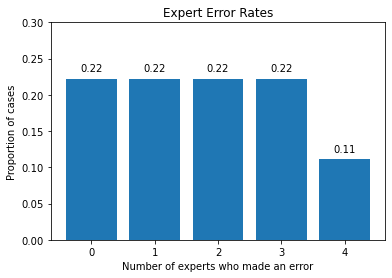

In [16]:
plt.bar(num_errors, proportion_errors)
plt.xlabel('Number of experts who made an error')
plt.ylabel('Proportion of cases')
plt.title('Expert Error Rates')
plt.ylim(top=.3)
plt.xticks(num_errors)
for i, proportion in enumerate(proportion_errors):
    plt.text(num_errors[i], proportion + 0.01, f'{proportion:.2f}', ha='center')
plt.show()

The bar chart shows the proportion of cases where different numbers of experts made an error. The proportion is the same at 0.22 for cases where 0, 1, 2, or 3 experts made an error, indicating that the majority of cases had high expert agreement. In contrast, the proportion drops to 0.11 when half of the experts made an error, suggesting that the level of agreement was lower in these cases. Overall, while expert agreement was relatively high, there were still a significant number of cases where only 50% or 62.5% of the experts agreed.

#### Crowd Agreement vs. Expert Agreement

We will now find how the proportion of the crowd that agrees with experts changes as the experts have different agreement levels.

First, filter out the rows where there is a discrepancy between the crowd and the experts, as this is not relevant for the current calculations.

In [17]:
df_filtered = df_new_columns[df_new_columns['Discrepancy between Experts and Crowd'] != 'Yes']

Find the average proportion of 'Crowd Agreement' for the different levels of 'Expert Agreement' (0.5, 0.625, 0.75, 0.875, and 1.0)

In [18]:
expert_levels = [0.5, 0.625, 0.75, 0.875, 1.0]
expert_filtered_df = df_filtered[df_filtered['Expert Agreement'].isin(expert_levels)]
expert_avg_df = expert_filtered_df.groupby('Expert Agreement').mean()

This line graph will show how the level of crowd agreement with the expert majority changes with the level of expert agreement with the expert majority

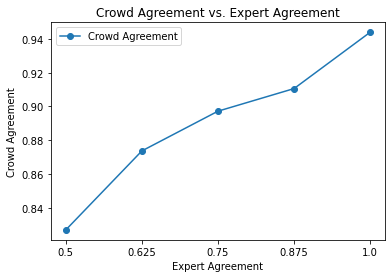

In [19]:
crowd_vs_exp = expert_avg_df.plot(kind='line', y='Crowd Agreement', marker='o')

crowd_vs_exp.set_xlabel('Expert Agreement')
crowd_vs_exp.set_ylabel('Crowd Agreement')
crowd_vs_exp.set_title('Crowd Agreement vs. Expert Agreement')

crowd_vs_exp.set_xticks([0.5, 0.625, 0.75, 0.875, 1.0])
crowd_vs_exp.set_xticklabels(['0.5', '0.625', '0.75', '0.875', '1.0'])

plt.show()

Based on the line graph, we can see that there is a positive relationship between the expert agreement level and the crowd agreement level. As the expert agreement level increases from 0.5 to 1.0, the crowd agreement level also increases from 0.82 to 0.95. This suggests that the crowd is more likely to agree with the experts when the expert agreement level is higher. It is also interesting to note that there is a relatively large increase in crowd agreement level between expert agreement levels of 0.5 and 0.625, and a smaller increase in crowd agreement level between expert agreement levels of 0.875 and 1.0. Overall, these findings suggest that the crowd can be a valuable resource for providing accurate information, particularly when expert agreement levels are high.

#### Crowd vs. Expert Agreement per Number of Expert Votes

We will plot the crowd and expert agreements for each number of Experts that voted 'yes' to the abnormality (0-8). Using this, we will hopefully be able to visualize how the agreement of the crowd and experts changes with the number of expert votes.

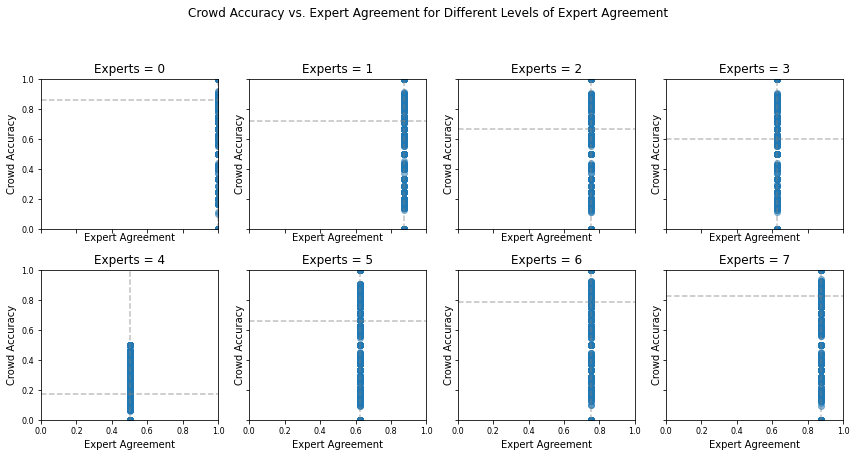

In [20]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(12,6), sharex=True, sharey=True)

for i, ax in enumerate(axs.flat):
    experts = i
    df_filtered = df_new_columns[df_new_columns['Experts Agreeing with Abnormality'] == experts]

    # Calculate crowd accuracy
    df_filtered['Crowd Accuracy'] = df_filtered.apply(lambda x: x['Crowd Agreement'] if x['Majority Label'] == x['Correct Label'] else 1 - x['Crowd Agreement'], axis=1)

    # Plot crowd accuracy
    ax.scatter(df_filtered['Expert Agreement'], df_filtered['Crowd Accuracy'], alpha=0.5)

    # Plot expert agreement line
    expert_agreement = df_filtered['Expert Agreement'].mean()
    ax.axvline(expert_agreement, linestyle='--', color='gray', alpha=0.5)

    # Plot crowd accuracy line
    crowd_agreement = df_filtered['Crowd Accuracy'].mean()
    ax.axhline(crowd_agreement, linestyle='--', color='gray', alpha=0.5)

    # Set x and y limits
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    # Set title
    ax.set_title(f"Experts = {experts}")

    # Set x and y labels and tick marks
    ax.set_xlabel('Expert Agreement')
    ax.set_ylabel('Crowd Accuracy')
    ax.tick_params(axis='both', which='major', labelsize=8)

fig.suptitle("Crowd Accuracy vs. Expert Agreement for Different Levels of Expert Agreement", fontsize=12, y=1.05)

plt.tight_layout()
plt.show()

The vertical lines in the graph represent the average expert accuracy for each number of 'yes' expert votes while the horizontal line represents the average crowd accuracy for each. As expected, the crowd accuracy lowers when expert accuracy lowers. Crowd accuracy is highest when expert votes are 0 (100% 'no' votes) or 8 (100% 'yes' votes).

### Accuracy as a Function of Difficulty

#### Expert vs. Crowd Accuracy for Differing Difficulties

Looking at how the accuracy of the experts and the crowd varies for differing difficulty levels can help determine how valueable expert opinions are/aren't for difficult cases.

Filter out the cases where "Correct Label" is NaN, as it will cause confusion when labeling correct and incorrect cases.

In [21]:
df_filtered = df_new_columns[(~df_new_columns['Correct Label'].isna()) | (df_new_columns['Experts Agreeing with Abnormality'] == 4)]

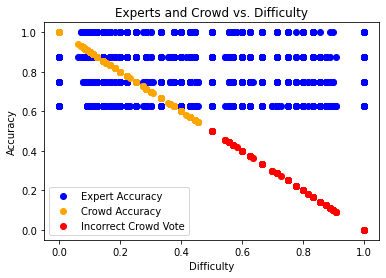

In [22]:
df_filtered['Expert Accuracy'] = df_filtered['Expert Agreement']

df_filtered['Crowd Accuracy'] = df_filtered.apply(lambda x: x['Crowd Agreement'] if x['Majority Label'] == x['Correct Label'] else 1 - x['Crowd Agreement'], axis=1)

fig, ax = plt.subplots()
ax.scatter(df_filtered['Difficulty'], df_new_columns['Expert Agreement'], label='Expert Accuracy', color='blue',)
ax.scatter(df_filtered['Difficulty'], df_filtered['Crowd Accuracy'], label='Crowd Accuracy', color='orange',)

incorrect_votes = df_filtered[(df_filtered['Majority Label'] != df_filtered['Correct Label']) & ~df_filtered['Correct Label'].isna()]
ax.scatter(incorrect_votes['Difficulty'], incorrect_votes['Crowd Accuracy'], label='Incorrect Crowd Vote', color='red')
ax.set_xlabel('Difficulty')
ax.set_ylabel('Accuracy')
ax.legend()
plt.title('Experts and Crowd vs. Difficulty')

plt.show()

Crowd accuracy as a function of difficulty is completely linear with a negative slope, which makes sense because Difficulty is a direct funtion of Incorrect Crowd Votes / Total Crowd Votes. Expert accuracy is not a direct function, so these lines are horizontal. The experts become much more accurate than the crowd as the difficulty increases.

#### Average Accuracies per Difficulty Level

The following chart will show the average accuracy scores for both the crowd and the experts for differing difficulty levels.

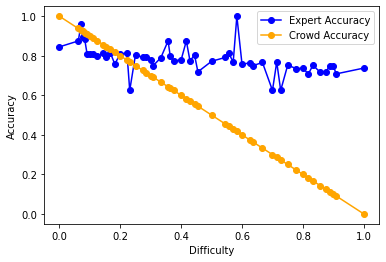

In [23]:
df_agg = df_filtered.groupby('Difficulty').agg({'Expert Accuracy': 'mean', 'Crowd Accuracy': 'mean'})

fig, ax = plt.subplots()
ax.plot(df_agg.index, df_agg['Expert Accuracy'], label='Expert Accuracy', color='blue', marker='o')
ax.plot(df_agg.index, df_agg['Crowd Accuracy'], label='Crowd Accuracy', color='orange', marker='o')
ax.set_xlabel('Difficulty')
ax.set_ylabel('Accuracy')
ax.legend()

plt.show()

In [24]:
difficulty_levels = [0.0, 0.25, 0.5, 0.75, 1.0]
crowd_accuracies = []
expert_accuracies = []
for level in difficulty_levels:
    level_df = df_filtered[df_filtered['Difficulty'] == level]
    crowd_accuracy = level_df['Crowd Accuracy'].mean()
    expert_accuracy = level_df['Expert Accuracy'].mean()
    crowd_accuracies.append(crowd_accuracy)
    expert_accuracies.append(expert_accuracy)
    print(f"For a difficulty of {level}, the average crowd accuracy is {crowd_accuracy:.2f} and the average expert accuracy is {expert_accuracy:.2f}")   

For a difficulty of 0.0, the average crowd accuracy is 1.00 and the average expert accuracy is 0.85
For a difficulty of 0.25, the average crowd accuracy is 0.75 and the average expert accuracy is 0.81
For a difficulty of 0.5, the average crowd accuracy is 0.50 and the average expert accuracy is 0.77
For a difficulty of 0.75, the average crowd accuracy is 0.25 and the average expert accuracy is 0.75
For a difficulty of 1.0, the average crowd accuracy is 0.00 and the average expert accuracy is 0.74


The crowd seems to consistently be more accurate than the experts from difficulty levels 0 to 0.2. At these levels, experts seem less useful, as the crowd is producing more accurate results. As the difficulty level increases however, the crowd gets significantly less accurate than the experts.

### Accuracy as a Function of Qualified Reads

#### Crowd Accuracy vs. Number of Crowd Votes

Now we will look at how the accuracy of the crowd is affected by the number of qualified reads (crowd votes) for each image.

Crowd accuracy exceeds expert accuracy at approximately 6.50 qualified reads


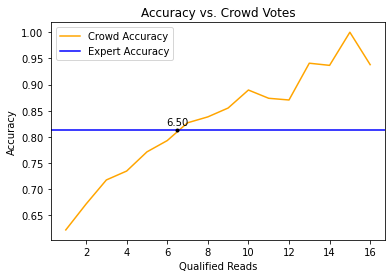

In [25]:
df_filtered = df_new_columns[(~df_new_columns['Correct Label'].isna())]
df_filtered['Expert Accuracy'] = df_filtered['Expert Agreement']
df_filtered['Crowd Accuracy'] = df_filtered.apply(lambda x: x['Crowd Agreement'] if x['Majority Label'] == x['Correct Label'] else 1 - x['Crowd Agreement'], axis=1)

avg_expert_accuracy = df_filtered['Expert Accuracy'].mean()

grouped = df_filtered.groupby('Qualified Reads').agg({'Crowd Accuracy': 'mean'})

fig, ax = plt.subplots()
ax.plot(grouped.index, grouped['Crowd Accuracy'], label='Crowd Accuracy', color='orange')
ax.axhline(y=avg_expert_accuracy, label='Expert Accuracy', color='blue')

x_intersect = np.mean([grouped.index[grouped['Crowd Accuracy'] <= avg_expert_accuracy].max(),grouped.index[grouped['Crowd Accuracy'] >= avg_expert_accuracy].min()])
y_intersect = avg_expert_accuracy

ax.plot(x_intersect, y_intersect, marker='o', markersize=3, color='black')
ax.annotate(f'{x_intersect:.2f}', xy=(x_intersect, y_intersect+0.01), ha='center')
ax.set_xlabel('Qualified Reads')
ax.set_ylabel('Accuracy')
ax.legend()
plt.title('Accuracy vs. Crowd Votes')

print("Crowd accuracy exceeds expert accuracy at approximately 6.50 qualified reads")
plt.show()

When the number of qualified reads is 7 or greater, the accuracy of the crowd is greater than the average expert accuracy. As the number of crowd votes increases, the confidence level in the accuracy of the crowd votes increases.

## Step 3: Admin Reads Analysis

Load admin reads data set. This contains the data for every user, problem, vote, and accuracy score which will be used in future analysis.

### Prep Admin Reads and Customer Results Data

In [26]:
file_path = "/Users/brynnrobbins/Desktop/medical data/1345_admin_reads.csv"
df_admin_reads = pd.read_csv(file_path)
df_admin_reads.head()

,topic_id,problem_id,user_id,read_id,labeling_state,patch,score,accuracy,contest_id,mission_id,content_id,chosen_answer,origin,origin_created_at,series,series_index,answerChoiceIds,response_submitted_at,problem_appeared_at
0,1345,5888087,55058,132610888,gold_standard,NaN,100,0.78,8011,NaN,3264386,['no'],https://centaur-customer-uploads.s3.us-east-1.amazonaws.com/mgh-eeg/210721/jpg/B14_time139137_medoid_vote2.jpg,2021-07-26 21:41:47.756010+00:00,NaN,NaN,[25796611],2022-04-12 09:20:24.912000+00:00,2022-04-12 09:20:24.415999+00:00
1,1345,5888087,248277,107696869,gold_standard,NaN,100,0.76,6437,NaN,3264386,['no'],https://centaur-customer-uploads.s3.us-east-1.amazonaws.com/mgh-eeg/210721/jpg/B14_time139137_medoid_vote2.jpg,2021-07-26 21:41:47.756010+00:00,NaN,NaN,[25796611],2021-12-04 15:00:58.596999+00:00,2021-12-04 15:00:56.760999+00:00
2,1345,5888088,19769,60673858,gold_standard,NaN,100,0.78,5183,NaN,3264387,['no'],https://centaur-customer-uploads.s3.us-east-1.amazonaws.com/mgh-eeg/210721/jpg/B10_time178433_medoid_vote0.jpg,2021-07-26 21:41:47.824498+00:00,NaN,NaN,[25796612],2021-08-09 07:41:17.754000+00:00,2021-08-09 07:41:16.961000+00:00
3,1345,5888088,237039,99676200,gold_standard,NaN,100,0.80,6151,NaN,3264387,['no'],https://centaur-customer-uploads.s3.us-east-1.amazonaws.com/mgh-eeg/210721/jpg/B10_time178433_medoid_vote0.jpg,2021-07-26 21:41:47.824498+00:00,NaN,NaN,[25796612],2021-11-01 12:05:16.948999+00:00,2021-11-01 12:05:16.076000+00:00
4,1345,5888088,280445,141519169,gold_standard,NaN,100,0.76,9076,NaN,3264387,['no'],https://centaur-customer-uploads.s3.us-east-1.amazonaws.com/mgh-eeg/210721/jpg/B10_time178433_medoid_vote0.jpg,2021-07-26 21:41:47.824498+00:00,NaN,NaN,[25796612],2022-06-10 12:16:45.950000+00:00,2022-06-10 12:16:45.112000+00:00


#### Drop Columns and Merge Dataframes

Drop all columns except 'problem_id', 'user_id', 'accuracy', and 'chosen_answer' to clean data frame.

In [27]:
df_admin_reads = df_admin_reads[['problem_id', 'user_id', 'accuracy', 'chosen_answer']]
df_admin_reads.head()

,problem_id,user_id,accuracy,chosen_answer
0,5888087,55058,0.78,['no']
1,5888087,248277,0.76,['no']
2,5888088,19769,0.78,['no']
3,5888088,237039,0.80,['no']
4,5888088,280445,0.76,['no']


Merge admin reads and customer results data frames together.

In [46]:
merged_df = df_admin_reads.merge(df_new_columns.reset_index()[['Case ID', 'Correct Label', 'Difficulty']], left_on='problem_id', right_on='Case ID')[['Case ID', 'user_id', 'accuracy', 'chosen_answer', 'Correct Label', 'Difficulty']]
merged_df.head()

,Case ID,user_id,accuracy,chosen_answer,Correct Label,Difficulty
0,5888087,55058,0.78,['no'],'no',0.0
1,5888087,248277,0.76,['no'],'no',0.0
2,5888088,19769,0.78,['no'],'no',0.0
3,5888088,237039,0.80,['no'],'no',0.0
4,5888088,280445,0.76,['no'],'no',0.0


Replace all NaN values under 'Difficulty' column with 0.

In [48]:
merged_df['Difficulty'] = merged_df['Difficulty'].fillna(0)

### Problem x User Matrix

The following problem user matrix displays the data from this merged data frame. It displays the problem id on the left which correlates with each specific case that the crowd voted for with each column, representing the amount of users that voted on the case. The number in each box represents the accuracy of each user on each case.

In [29]:
import pandas as pd

problem_user_matrix = pd.pivot_table(df_admin_reads, values='accuracy', index='problem_id', columns='user_id')
problem_user_matrix.columns = ['User ' + str(col) for col in problem_user_matrix.columns]
problem_user_matrix.head()

,User 1196,User 1858,User 2581,User 2815,User 2861,User 7280,User 11697,User 11715,User 15245,User 19769,User 21682,User 30879,User 32053,User 37193,User 38179,User 41816,User 42266,User 43096,User 44164,User 44512,User 44529,User 45825,User 46115,User 46403,User 46967,User 47705,User 48054,User 48437,User 48870,User 49472,User 49560,User 50205,User 50342,User 50420,User 51197,User 52355,User 52785,User 52882,User 52979,User 53036,User 53129,User 53717,User 53744,User 53789,User 54178,User 54870,User 54890,User 55058,User 55188,User 55386,User 55411,User 55422,User 55602,User 55669,User 55672,User 56746,User 56959,User 57188,User 57507,User 57749,User 57851,User 62640,User 62945,User 63450,User 63821,User 64460,User 64472,User 64485,User 64513,User 64625,User 64667,User 64701,User 64885,User 65046,User 65094,User 65129,User 65244,User 65368,User 65588,User 65621,User 65699,User 65854,User 66136,User 66589,User 66654,User 67217,User 67350,User 67615,User 67879,User 68333,User 68409,User 68904,User 69061,User 69599,User 71806,User 71885,User 78505,User 80367,User 84307,User 84759,User 87206,User 90170,User 94530,User 98931,User 99033,User 99146,User 99820,User 100457,User 101978,User 102375,User 102777,User 103017,User 103139,User 104231,User 104357,User 104694,User 105321,User 105711,User 107650,User 110433,User 112839,User 113465,User 114283,User 114389,User 114957,User 115065,User 115071,User 115088,User 115094,User 115125,User 115295,User 116576,User 117044,User 118059,User 118064,User 119391,User 119656,User 119850,User 119939,User 120668,User 120988,User 121394,User 121612,User 121909,User 122607,User 122901,User 122904,User 123160,User 123180,User 123392,User 123754,User 125048,User 125362,User 126201,User 126656,User 126914,User 127786,User 127794,User 127883,User 128538,User 128820,User 128872,User 129198,User 129201,User 129700,User 130025,User 130084,User 130230,User 130485,User 130547,User 130766,User 130904,User 130928,User 130978,User 131059,User 131174,User 131314,User 131544,User 131744,User 131793,User 131906,User 131945,User 132095,User 132224,User 132272,User 132433,User 132459,User 132541,User 133064,User 133614,User 133630,User 133646,User 133738,User 133739,User 134015,User 134181,User 134321,User 134562,User 134865,User 135031,User 135477,User 136027,User 136162,User 136644,User 136672,User 136932,User 137179,User 137347,User 137392,User 137488,User 137730,User 137759,User 137868,User 137983,User 138291,User 138292,User 138317,User 138467,User 138471,User 138570,User 138685,User 138985,User 139001,User 139140,User 139514,User 139516,User 139696,User 139736,User 139763,User 139917,User 140211,User 140537,User 140647,User 141324,User 141335,User 141601,User 141655,User 141668,User 141924,User 141983,User 142175,User 142217,User 142399,User 142622,User 142690,User 142774,User 143035,User 143074,User 143164,User 143178,User 143270,User 143344,User 143397,User 143541,User 143562,User 143792,User 143831,User 144146,User 144712,User 144910,User 145041,User 145203,User 145216,User 145318,User 145323,User 145348,User 145527,User 145576,User 145590,User 145621,User 145848,User 145853,User 145876,User 145986,User 146383,User 146384,User 146604,User 146708,User 146852,User 146881,User 146897,User 146904,User 147009,User 147030,User 147056,User 147231,User 147290,User 147346,User 147367,User 147428,User 147480,User 147591,User 147639,User 147652,User 147719,User 147720,User 147736,User 147811,User 147908,User 148036,User 148136,User 148159,User 148215,User 148343,User 148351,User 148435,User 148452,User 148457,User 148499,User 148514,User 148605,User 148701,User 148717,User 148723,User 148919,User 149136,User 149304,User 149372,User 149394,User 149421,User 149478,User 149527,User 149558,User 149594,User 149966,User 150045,User 150226,User 150294,User 150306,User 150307,User 150352,User 150355,User 150503,User 150586,User 150726,User 150761,User 150843,User 150851,User 150964,User 151012,User 151016,User 151102,User 151

#### Train & Test Data

Create the X and y frames for the test and train data sets.

In [30]:
X = merged_df.drop(["Correct Label"], axis=1)
y = merged_df["Correct Label"]

Training and test sets are created for the x frames (problem_id, user_id, accuracy, problem_user_matrix) and the y label (Correct Label).

In [31]:
from sklearn.model_selection import train_test_split

# split X and y into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Create another problem user matrix that replaces all NaN values for each user with 0.

In [32]:
problem_user_matrix2 = df_admin_reads.groupby(['problem_id', 'user_id'])['accuracy'].mean().unstack()

problem_user_matrix2.fillna(0, inplace=True)
problem_user_matrix2.columns = ['User ' + str(col) for col in problem_user_matrix2.columns]

problem_user_matrix2 = problem_user_matrix2.reset_index().set_index('problem_id')
problem_user_matrix2.head()

,User 1196,User 1858,User 2581,User 2815,User 2861,User 7280,User 11697,User 11715,User 15245,User 19769,User 21682,User 30879,User 32053,User 37193,User 38179,User 41816,User 42266,User 43096,User 44164,User 44512,User 44529,User 45825,User 46115,User 46403,User 46967,User 47705,User 48054,User 48437,User 48870,User 49472,User 49560,User 50205,User 50342,User 50420,User 51197,User 52355,User 52785,User 52882,User 52979,User 53036,User 53129,User 53717,User 53744,User 53789,User 54178,User 54870,User 54890,User 55058,User 55188,User 55386,User 55411,User 55422,User 55602,User 55669,User 55672,User 56746,User 56959,User 57188,User 57507,User 57749,User 57851,User 62640,User 62945,User 63450,User 63821,User 64460,User 64472,User 64485,User 64513,User 64625,User 64667,User 64701,User 64885,User 65046,User 65094,User 65129,User 65244,User 65368,User 65588,User 65621,User 65699,User 65854,User 66136,User 66589,User 66654,User 67217,User 67350,User 67615,User 67879,User 68333,User 68409,User 68904,User 69061,User 69599,User 71806,User 71885,User 78505,User 80367,User 84307,User 84759,User 87206,User 90170,User 94530,User 98931,User 99033,User 99146,User 99820,User 100457,User 101978,User 102375,User 102777,User 103017,User 103139,User 104231,User 104357,User 104694,User 105321,User 105711,User 107650,User 110433,User 112839,User 113465,User 114283,User 114389,User 114957,User 115065,User 115071,User 115088,User 115094,User 115125,User 115295,User 116576,User 117044,User 118059,User 118064,User 119391,User 119656,User 119850,User 119939,User 120668,User 120988,User 121394,User 121612,User 121909,User 122607,User 122901,User 122904,User 123160,User 123180,User 123392,User 123754,User 125048,User 125362,User 126201,User 126656,User 126914,User 127786,User 127794,User 127883,User 128538,User 128820,User 128872,User 129198,User 129201,User 129700,User 130025,User 130084,User 130230,User 130485,User 130547,User 130766,User 130904,User 130928,User 130978,User 131059,User 131174,User 131314,User 131544,User 131744,User 131793,User 131906,User 131945,User 132095,User 132224,User 132272,User 132433,User 132459,User 132541,User 133064,User 133614,User 133630,User 133646,User 133738,User 133739,User 134015,User 134181,User 134321,User 134562,User 134865,User 135031,User 135477,User 136027,User 136162,User 136644,User 136672,User 136932,User 137179,User 137347,User 137392,User 137488,User 137730,User 137759,User 137868,User 137983,User 138291,User 138292,User 138317,User 138467,User 138471,User 138570,User 138685,User 138985,User 139001,User 139140,User 139514,User 139516,User 139696,User 139736,User 139763,User 139917,User 140211,User 140537,User 140647,User 141324,User 141335,User 141601,User 141655,User 141668,User 141924,User 141983,User 142175,User 142217,User 142399,User 142622,User 142690,User 142774,User 143035,User 143074,User 143164,User 143178,User 143270,User 143344,User 143397,User 143541,User 143562,User 143792,User 143831,User 144146,User 144712,User 144910,User 145041,User 145203,User 145216,User 145318,User 145323,User 145348,User 145527,User 145576,User 145590,User 145621,User 145848,User 145853,User 145876,User 145986,User 146383,User 146384,User 146604,User 146708,User 146852,User 146881,User 146897,User 146904,User 147009,User 147030,User 147056,User 147231,User 147290,User 147346,User 147367,User 147428,User 147480,User 147591,User 147639,User 147652,User 147719,User 147720,User 147736,User 147811,User 147908,User 148036,User 148136,User 148159,User 148215,User 148343,User 148351,User 148435,User 148452,User 148457,User 148499,User 148514,User 148605,User 148701,User 148717,User 148723,User 148919,User 149136,User 149304,User 149372,User 149394,User 149421,User 149478,User 149527,User 149558,User 149594,User 149966,User 150045,User 150226,User 150294,User 150306,User 150307,User 150352,User 150355,User 150503,User 150586,User 150726,User 150761,User 150843,User 150851,User 150964,User 151012,User 151016,User 151102,User 151

Find the average accuracy score for each user by calculating the mean of all non-zero accuracy scores.

In [33]:
problem_user_matrix2.index.name = 'problem_id'

user_data = []
for col in problem_user_matrix2.columns:
    non_zero_vals = problem_user_matrix2[col][problem_user_matrix2[col] != 0]
    if len(non_zero_vals) > 0:
        avg_val = non_zero_vals.mean()
        user_data.append({'User ID': col, 'Accuracy Score': avg_val})

user_df = pd.DataFrame(user_data)
sorted_user_df = user_df.sort_values(by='Accuracy Score', ascending=False)

print(sorted_user_df.head(10))

          User ID  Accuracy Score
1005  User 285036        0.941818
687   User 237634        0.886071
323   User 149594        0.885682
489   User 175050        0.876563
44     User 54178        0.862857
784   User 257418        0.862727
771   User 255213        0.862500
756   User 253293        0.861500
346   User 151343        0.856667
712   User 243441        0.849091


These are the 10 most accurate users and their average accuracy scores in this dataframe.

### Accuracy vs. Number of Votes

This scatterplot will show the correlation between the average accuracy score of each user and the number of times each user has voted. The average user accuracy score is calculated by averaging all nonzero values and the number of user votes is the number of all nonzero values for each user.

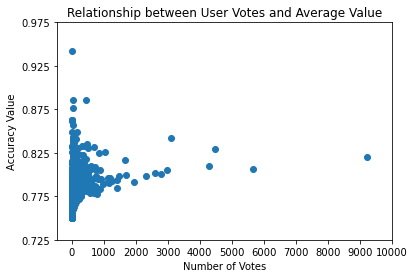

In [34]:
problem_user_matrix2.index.name = 'problem_id'

user_data = []
for col in problem_user_matrix2.columns:
    non_zero_vals = problem_user_matrix2[col][problem_user_matrix2[col] != 0]
    avg_val = non_zero_vals.mean()
    num_votes = len(non_zero_vals)
    user_data.append({'User ID': col, 'Avg Value': avg_val, 'Num Votes': num_votes})

user_df = pd.DataFrame(user_data)

plt.scatter(user_df['Num Votes'], user_df['Avg Value'])
plt.xticks(range(0, 11000, 1000))
plt.ylim(0.725, 0.95)
plt.yticks([0.725, 0.775, 0.825, 0.875, 0.925, 0.975])
plt.xlabel('Number of Votes')
plt.ylabel('Accuracy Value')
plt.title('Relationship between User Votes and Average Value')
plt.show()

The scatterplot shows that most users have contributed a rather small number of votes (>1000) and accuracy values range from 0.75-0.95. This ultimately shows that there isn't much of a correlation between average accuracy values and number of votes.

#### Highest Accuracy

Find the number of votes for each of the users in the top 10 accuracy scores.

In [35]:
problem_user_matrix2.index.name = 'problem_id'

user_data = []
for col in problem_user_matrix2.columns:
    non_zero_vals = problem_user_matrix2[col][problem_user_matrix2[col] != 0]
    if len(non_zero_vals) > 0:
        avg_val = non_zero_vals.mean()
        num_votes = len(non_zero_vals)
        user_data.append({'User ID': col, 'Accuracy Score': avg_val, 'Num Votes': num_votes})

user_df = pd.DataFrame(user_data)

top_users = user_df.sort_values(by='Accuracy Score', ascending=False).head(10)
print('Top 10 Most Accurate Users:')
print(top_users)

avg_num_votes = user_df['Num Votes'].median()
print(f"\nMedian number of votes for all users: {avg_num_votes:.2f}")

Top 10 Most Accurate Users:
          User ID  Accuracy Score  Num Votes
1005  User 285036        0.941818         22
687   User 237634        0.886071         28
323   User 149594        0.885682        447
489   User 175050        0.876563         32
44     User 54178        0.862857         21
784   User 257418        0.862727         22
771   User 255213        0.862500         20
756   User 253293        0.861500         20
346   User 151343        0.856667         42
712   User 243441        0.849091         22

Median number of votes for all users: 43.00


All users excpet for one (User 149594) had a lower number of votes than the median. This could be due to the fact that these users have had less of a chance to make mistakes than those who have voted more, that they haven't encountered all of the difficult problems, or that they are simply more knowledgeable about labeling medical images.

#### Lowest Accuracy

We will now find the accuracy scores and number of votes for the bottom 10 and middle 10 voters.

In [56]:
problem_user_matrix2.index.name = 'problem_id'

user_data = []
for col in problem_user_matrix2.columns:
    non_zero_vals = problem_user_matrix2[col][problem_user_matrix2[col] != 0]
    if len(non_zero_vals) > 0:
        avg_val = non_zero_vals.mean()
        num_votes = len(non_zero_vals)
        user_data.append({'User ID': col, 'Accuracy Score': avg_val, 'Num Votes': num_votes})
        
user_df = pd.DataFrame(user_data)
low_acc_users = user_df.sort_values(by='Accuracy Score', ascending=True).head(10)

print('Top 10 Least Accurate Users:')
print(low_acc_users)

Top 10 Least Accurate Users:
         User ID  Accuracy Score  Num Votes
68    User 64513            0.75          3
483  User 174268            0.75          1
874  User 268122            0.75          1
776  User 256126            0.75          1
96    User 78505            0.75          3
693  User 238510            0.75          3
154  User 126656            0.75          3
869  User 267651            0.75          3
863  User 267439            0.75          1
409  User 158731            0.75          3


The bottom 10 voters all have an accuracy score of 0.75 and none have voted more than 3 times. This shows that the more that users vote, the more they can improve their accuracy score.

#### Middle Accuracy

In [37]:
sorted_users = user_df.sort_values(by='Avg Value')

middle_10_users = sorted_users.iloc[int(len(sorted_users) / 2) - 5: int(len(sorted_users) / 2) + 5]

print("User ID\t        Accuracy Score\tNum Votes")
for user in middle_10_users.itertuples():
    print(f"{user[1]}\t{user[2]:.6f}\t{user[3]}")

User ID	        Accuracy Score	Num Votes
User 149372	0.776211	190
User 188378	0.776271	59
User 230053	0.776327	98
User 260811	0.776364	77
User 47705	0.776429	210
User 238581	0.776471	85
User 261093	0.776471	34
User 171070	0.776545	191
User 274909	0.776591	44
User 181978	0.776632	95


The middle 10 voters all have much higher vote counts than the median number of votes, which is 43.

#### Accuracy vs. Votes Graph

The following graph will group the users into 3 separate groups: Least Accuracy, Average Accuracy, Most Accuracy. These users are broken into groups based on their percentile of median accuracy score. The graph will then separate these users by color and plot their accuracy scores vs. the numbe of times they have voted.

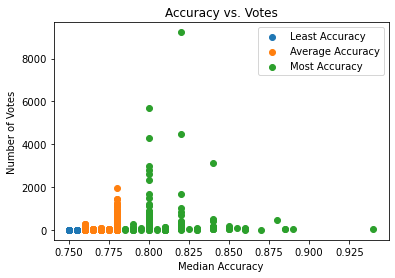

In [67]:
median_accuracy = []
for user in problem_user_matrix2.columns:
    user_data = problem_user_matrix2[user]
    non_zero_accuracy = user_data[user_data != 0]
    median = np.median(non_zero_accuracy)
    median_accuracy.append(median)

num_votes = problem_user_matrix2.astype(bool).sum(axis=0)

user_accuracy_votes = pd.DataFrame({'Median Accuracy': median_accuracy, 'Num Votes': num_votes})

least_accurate = user_accuracy_votes[user_accuracy_votes['Median Accuracy'] < np.percentile(user_accuracy_votes['Median Accuracy'], 33)]
average_accuracy = user_accuracy_votes[(user_accuracy_votes['Median Accuracy'] >= np.percentile(user_accuracy_votes['Median Accuracy'], 33)) & (user_accuracy_votes['Median Accuracy'] <= np.percentile(user_accuracy_votes['Median Accuracy'], 67))]
most_accurate = user_accuracy_votes[user_accuracy_votes['Median Accuracy'] > np.percentile(user_accuracy_votes['Median Accuracy'], 67)]

plt.scatter(least_accurate['Median Accuracy'], least_accurate['Num Votes'], label='Least Accuracy')
plt.scatter(average_accuracy['Median Accuracy'], average_accuracy['Num Votes'], label='Average Accuracy')
plt.scatter(most_accurate['Median Accuracy'], most_accurate['Num Votes'], label='Most Accuracy')
plt.xlabel('Median Accuracy')
plt.ylabel('Number of Votes')
plt.title('Accuracy vs. Votes')
plt.legend()
plt.show()

The outliers for number of votes are all in the most accurate group, which proves that those users are consistently accurate and their opinions should be weighed heavier than most. The least accurate group all have the lowest number of votes and the middle group has low-medium number of votes. The most accurate group has plenty of users that hve low number of votes but has a much higher range than the other 2 groups.

### Difficulty vs. Accuracy

We will now explore how difficulty scores vary with different user accuracy levels. 

#### Top 10 Accuracy Scores

In [52]:
user_ids = [285036, 237634, 149594, 175050, 54178, 257418, 255213, 253293, 151343, 243441]
difficulty_scores_top10 = merged_df.loc[merged_df['user_id'].isin(user_ids) & (merged_df['Difficulty'] != 0), 'Difficulty']

for user_id in user_ids:
    median_difficulty = np.median(difficulty_scores_top10[merged_df['user_id'] == user_id])
    print(f"User {user_id}: {median_difficulty}")

median_difficulty_all = np.median(merged_df.loc[merged_df['Difficulty'] != 0, 'Difficulty'])
print(f"Median difficulty score for all users: {median_difficulty_all}")

User 285036: 0.429
User 237634: 0.45
User 149594: 0.4
User 175050: 0.4
User 54178: 0.333
User 257418: 0.2
User 255213: 0.4
User 253293: 0.5
User 151343: 0.325
User 243441: 0.333
Median difficulty score for all users: 0.375


The median difficulty scores for the top 10 users range above and below the median difficulty score for all users. This shows that the high accuracy scores for these users is not because they are voting on less difficult images. The highest liklihood is that these users are simply more knowledgeable about labeling medical images.

#### Bottom 10 Accuracy Scores

In [60]:
user_ids = [64513, 174268, 268122, 256126, 78505, 238510, 126656, 267651, 267439, 158731]
difficulty_scores_top10 = merged_df.loc[merged_df['user_id'].isin(user_ids), 'Difficulty']

for user_id in user_ids:
    median_difficulty = np.median(difficulty_scores_top10[(merged_df['user_id'] == user_id) & (merged_df['Difficulty'] != 0)])
    print(f"User {user_id}: {median_difficulty}")

median_difficulty_all = np.median(merged_df.loc[merged_df['Difficulty'] != 0, 'Difficulty'])
print(f"Median difficulty score for all users: {median_difficulty_all}")

User 64513: nan
User 174268: nan
User 268122: 0.5
User 256126: nan
User 78505: 0.5
User 238510: nan
User 126656: 0.4585
User 267651: nan
User 267439: 0.5
User 158731: nan
Median difficulty score for all users: 0.375


Since all of these users have only voted a maximum of 3 times, there is not a lot of difficulty data to analyze. The 3 users that have difficulty data all have voted for images that are more difficult than the median, which could be the reason that they are so low on accuracy.

#### Middle 10 Accuracy Scores

In [61]:
user_ids = [149372, 188378, 230053, 260811, 47705, 238581, 261093, 171070, 274909, 181978]
difficulty_scores_top10 = merged_df.loc[merged_df['user_id'].isin(user_ids), 'Difficulty']

for user_id in user_ids:
    median_difficulty = np.median(difficulty_scores_top10[(merged_df['user_id'] == user_id) & (merged_df['Difficulty'] != 0)])
    print(f"User {user_id}: {median_difficulty}")

median_difficulty_all = np.median(merged_df.loc[merged_df['Difficulty'] != 0, 'Difficulty'])
print(f"Median difficulty score for all users: {median_difficulty_all}")

User 149372: 0.375
User 188378: 0.5
User 230053: 0.375
User 260811: 0.4
User 47705: 0.4
User 238581: 0.5
User 261093: 0.45
User 171070: 0.333
User 274909: 0.286
User 181978: 0.4645
Median difficulty score for all users: 0.375


The middle 10 users have accuracy scores hovering over the overall media, which makes sense. The users in the middle of the pack seem to get the most average images in terms of difficulty.

Overall, there does not seem to be much of a correlation between the difficulty scores of images and how well users are performing. The correlation seems to exist more in how many times users have voted on certain images than how difficult the images are. The users that are performing the most accurately most likely have more knowledge. The users that are not performing well are those who have barely voted. The users that are performing the most averagely have voted more than both the most accurate and the least accurate, and also have the difficulty scores closer to the median. This supports the overall idea that the more that the average user votes, the closer they will get to the median in terms of accuracy and difficulty, with the excpetion of the top performing users.